# Distributional Deep Q-Networks


In [ ]:
!apt-get install -y xvfb

!pip install \
  gym[atari,accept-rom-license]==0.23.1 \
  pytorch-lightning==1.6.0 \
  stable-baselines3 \
  pyvirtualdisplay

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [1]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation, NormalizeObservation, \
  NormalizeReward, RecordVideo, RecordEpisodeStatistics, AtariPreprocessing


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [2]:
def display_video(episode=0):
  video_file = open(f'videos1/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [3]:
import math 
from torch.nn.init import kaiming_uniform_, zeros_

class NoisyLinear(nn.Module):

  def __init__(self, in_features, out_features, sigma):
    super(NoisyLinear, self).__init__()
    self.w_mu = nn.Parameter(torch.empty((out_features, in_features)))
    self.w_sigma = nn.Parameter(torch.empty((out_features, in_features)))
    self.b_mu = nn.Parameter(torch.empty((out_features)))
    self.b_sigma = nn.Parameter(torch.empty((out_features)))

    kaiming_uniform_(self.w_mu, a=math.sqrt(5))
    kaiming_uniform_(self.w_sigma, a=math.sqrt(5))
    zeros_(self.b_mu)
    zeros_(self.b_sigma)
    
  def forward(self, x, sigma=0.5):
    if self.training:
      w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(device)
      b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(device)
      return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
    else:
      return F.linear(x, self.W_mu, self.b_mu)

In [4]:
class DQN(nn.Module):

  def __init__(self, hidden_size, obs_shape, n_actions, atoms=51, sigma=0.5):
    super().__init__()
    self.atoms = atoms
    self.n_actions = n_actions
    
    self.conv = nn.Sequential(
      nn.Conv2d(obs_shape[0], 64, kernel_size=3),
      nn.MaxPool2d(kernel_size=4),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.MaxPool2d(kernel_size=4),
      nn.ReLU()
    )
    conv_out_size = self._get_conv_out(obs_shape)
    self.head = nn.Sequential(
      NoisyLinear(conv_out_size, hidden_size, sigma=sigma),
      nn.ReLU(),
    )

    self.fc_adv = NoisyLinear(hidden_size, self.n_actions * self.atoms, sigma=sigma) 
    self.fc_value = NoisyLinear(hidden_size, self.atoms, sigma=sigma)

  def _get_conv_out(self, shape):
    conv_out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(conv_out.size()))
  
  def forward(self, x):
    x = self.conv(x.float()).view(x.size()[0], -1)
    x = self.head(x)
    adv = self.fc_adv(x).view(-1, self.n_actions, self.atoms)  # (B, A*N) -> (B, A, N)
    value = self.fc_value(x).view(-1, 1, self.atoms)  # (B, 1, N)
    q_logits = value + adv - adv.mean(dim=1, keepdim=True)  # (B, A, N)
    q_probs = F.softmax(q_logits, dim=-1)  # (B, A, N)
    return q_probs

#### Create the policy

In [6]:
def greedy(state, net, support):
  state = torch.tensor([state]).to(device)
  q_value_probs = net(state)  # (1, A, N) 
  q_values = (support * q_value_probs).sum(dim=-1)  # (1, A)
  #we are computing the weighted probablities here
  action = torch.argmax(q_values, dim=-1)  # (1, 1)
  action = int(action.item())  # ()
  return action

#### Create the replay buffer

In [7]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)
    self.priorities = deque(maxlen=capacity)
    self.capacity = capacity
    self.alpha = 0.0  # anneal.
    self.beta = 1.0  # anneal.
    self.max_priority = 0.0

  def __len__(self):
    return len(self.buffer)
  
  def append(self, experience):
    self.buffer.append(experience)
    self.priorities.append(self.max_priority)
  
  def update(self, index, priority):
    if priority > self.max_priority:
      self.max_priority = priority
    self.priorities[index] = priority

  def sample(self, batch_size):
    prios = np.array(self.priorities, dtype=np.float64) + 1e-4 # Stability constant.
    prios = prios ** self.alpha
    probs = prios / prios.sum()

    weights = (self.__len__() * probs) ** -self.beta
    weights = weights / weights.max()

    idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
    sample = [(i, weights[i], *self.buffer[i]) for i in idx]
    return sample

In [8]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size
  
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

#### Create the environment

In [9]:
env = gym.make('QbertNoFrameskip-v4')

In [10]:
env.observation_space, env.action_space

(Box(0, 255, (210, 160, 3), uint8), Discrete(6))

d:\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


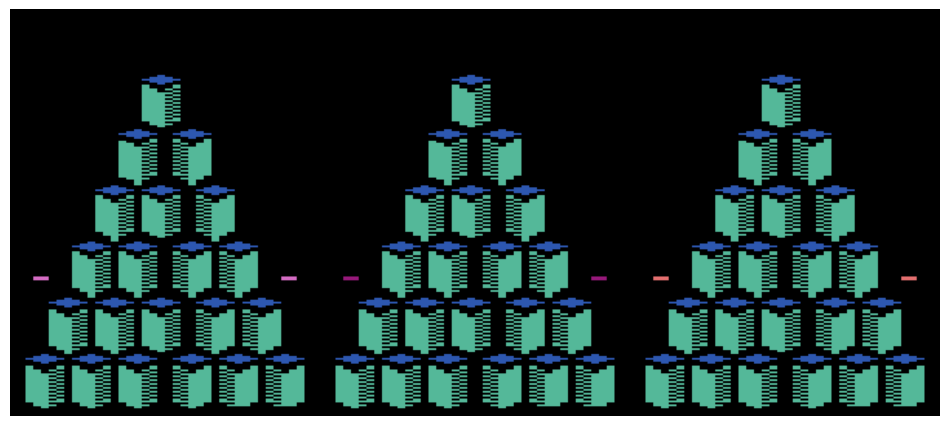

In [11]:
frames = []
i = 60
skip = 8
obs, _ = env.reset()
done = False
truncate = False
while not (done or truncate):
  frames.append(obs)
  obs, _, done, truncate, _ = env.step(env.action_space.sample())

frames = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(frames)

In [12]:
env = AtariPreprocessing(env, frame_skip=8, screen_size=42)

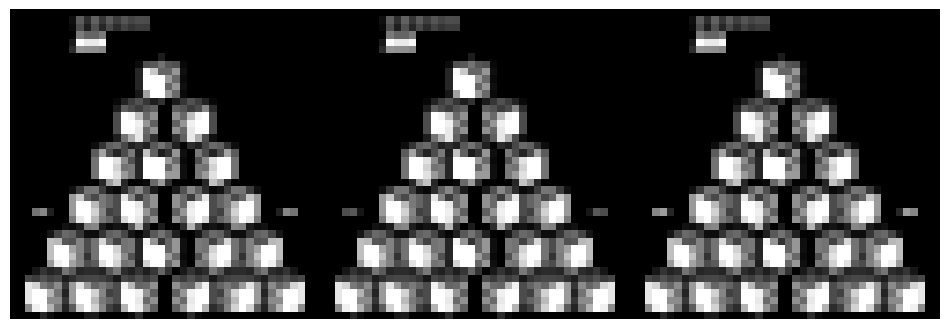

In [13]:
frames = []
i = 40
skip = 1
obs, _ = env.reset()
done = False
truncate = False
while not (done or truncate):
  frames.append(obs)
  obs, _, done, truncate, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(img, cmap='gray')

In [14]:
env = NormalizeObservation(env)

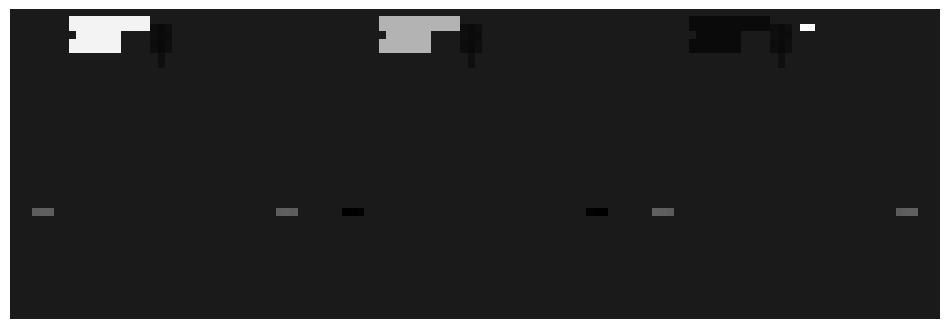

In [15]:
frames = []
i = 100
skip = 1

for i in range(20):
  obs, _ = env.reset()
  done = False
  truncate = False
  while not (done or truncate):
    frames.append(obs)
    obs, _, done, truncate, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(img.squeeze(), cmap='gray')

In [19]:
def create_environment(name):
  env = gym.make(name, render_mode='rgb_array')
  env = RecordVideo(env, 'videos1', episode_trigger=lambda e: e % 100 == 0)
  env = AtariPreprocessing(env, frame_skip=8, screen_size=42)
  env = RecordEpisodeStatistics(env)
  env = TransformObservation(env, lambda x: x[np.newaxis,:,:])
  env.observation_space = gym.spaces.Box(low=0, high=1, shape=(1, 42, 42), dtype=np.float32)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

In [20]:
env = create_environment('QbertNoFrameskip-v4')
frames = []
for episode in range(10):
  done = False
  truncate = False
  obs, _ = env.reset()
  while not (done or truncate):
    frames.append(obs)
    action = env.action_space.sample()
    obs, _, done, truncate, _ = env.step(action)

Moviepy - Building video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-0.mp4


In [21]:
display_video(episode=0)

#### Create the Deep Q-Learning algorithm

In [22]:
class DeepQLearning(LightningModule):

  # Initialize.
  def __init__(self, env_name, policy=greedy, capacity=100_000, 
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99, 
               loss_fn=F.smooth_l1_loss, optim=AdamW, samples_per_epoch=10_000, 
               sync_rate=10, sigma=0.5, a_start=0.5, a_end=0.0, a_last_episode=100, 
               b_start=0.4, b_end=1.0, b_last_episode=100, n_steps=3, 
               v_min=-10.0, v_max=10.0, atoms=51):
    
    super().__init__()

    self.support = torch.linspace(v_min, v_max, atoms, device=device)  # (N)
    self.delta = (v_max - v_min) / (atoms - 1)

    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions, atoms=atoms, sigma=sigma)

    self.target_q_net = copy.deepcopy(self.q_net)

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode()
    
  @torch.no_grad()
  def play_episode(self, policy=None):
    state, _ = self.env.reset()
    done = False
    truncate = False
    transitions = []

    while not (done or truncate):
      if policy:
        action = policy(state, self.q_net, self.support)
      else:
        action = self.env.action_space.sample()
      
      next_state, reward, done, truncate, info = self.env.step(action)
      exp = (state, action, reward, (done or truncate), next_state)
      transitions.append(exp)
      state = next_state

    for i, (s, a, r, d, ns) in enumerate(transitions):
      batch = transitions[i:i+self.hparams.n_steps]
      ret = sum([t[2] * self.hparams.gamma**j for j, t in enumerate(batch)])
      _, _, _, ld, ls = batch[-1]
      self.buffer.append((s, a, ret, ld, ls))

  # Forward.
  def forward(self, x):
    return self.q_net(x)

  # Configure optimizers.
  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  # Create dataloader.
  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  # Training step.
  def training_step(self, batch, batch_idx):
    indices, weights, states, actions, returns, dones, next_states = batch
    #since our tensors will have different dimensions, this time, we won't need to squeeze wieghts and actions
    returns = returns.unsqueeze(1)
    dones = dones.unsqueeze(1)
    batch_size = len(indices)

    q_value_probs = self.q_net(states)  # (B, A, N)
    #this q_value_probs contains the probabilities associated with every possible action with each state 
    #and we want to gather the probabilities associated with the action that we effectively took 
    #we do that with the help of the following line of code
    action_value_probs = q_value_probs[range(batch_size), actions, :]  # (B, N)
    log_action_value_probs = torch.log(action_value_probs + 1e-6)  # (B, N)

    with torch.no_grad():
      next_q_value_probs = self.q_net(next_states)  # (B, A, N)
      next_q_values = (next_q_value_probs * self.support).sum(dim=-1)  # (B, A)
      next_actions = next_q_values.argmax(dim=-1)  # (B,)

      next_q_value_probs = self.target_q_net(next_states)  # (B, A, N)
      next_action_value_probs = next_q_value_probs[range(batch_size), next_actions, :]  # (B, N)

    #main change
    m = torch.zeros(batch_size * self.hparams.atoms, device=device, dtype=torch.float64)  # (B * N)

    Tz = returns + ~dones * self.hparams.gamma**self.hparams.n_steps * self.support.unsqueeze(0)  # (B, N)

    Tz.clamp_(min=self.hparams.v_min, max=self.hparams.v_max)  # (B, N)
    b = (Tz - self.hparams.v_min) / self.delta  # (B, N)
    l, u = b.floor().long(), b.ceil().long()  # (B, N)

    ######I couldn't udnerstand the following lines of code, although I did understood the algorithm
    offset = torch.arange(batch_size, device=device).view(-1, 1) * self.hparams.atoms  # (B, 1)

    l_idx = (l + offset).flatten()  # (B * N)
    u_idx = (u + offset).flatten()  # (B * N)
    
    upper_probs = (next_action_value_probs * (u - b)).flatten()  # (B * N)
    lower_probs = (next_action_value_probs * (b - l)).flatten()  # (B * N)

    m.index_add_(dim=0, index=l_idx, source=upper_probs)
    m.index_add_(dim=0, index=u_idx, source=lower_probs)

    m = m.reshape(batch_size, self.hparams.atoms)  # (B, N)

    cross_entropies = - (m * log_action_value_probs).sum(dim=-1)  # (B,)

    for idx, e in zip(indices, cross_entropies):
      self.buffer.update(idx, e.detach().item())

    loss = (weights * cross_entropies).mean()

    self.log('episode/Q-Error', loss)
    return loss

  # Training epoch end.
  def on_train_epoch_end(self):
    alpha = max(
        self.hparams.a_end,
        self.hparams.a_start - self.current_epoch / self.hparams.a_last_episode
    )
    beta = min(
        self.hparams.b_end,
        self.hparams.b_start + self.current_epoch / self.hparams.b_last_episode
    )
    self.buffer.alpha = alpha
    self.buffer.beta = beta

    self.play_episode(policy=self.policy)
    self.log('episode/Return', self.env.return_queue[-1])

    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [23]:
algo = DeepQLearning(
  'QbertNoFrameskip-v4',
  lr=0.0001,
  sigma=0.5,
  hidden_size=512,
  a_last_episode=2_000,
  b_last_episode=2_000,
  n_steps=8,
)

trainer = Trainer(
  # gpus=num_gpus,
  max_epochs=2_400,
  log_every_n_steps=1
)

trainer.fit(algo)

d:\anaconda3\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at d:\Reinforcement Learning\advanced_dqn_complete-main\videos1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
d:\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
d:\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 samples in experience buffer. Filling...
Moviepy - Building video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-0.mp4.
Moviepy - Writing video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-0.mp4
158 samples in experience buffer. Filling...
341 samples in experience buffer. Filling...
478 samples in experience buffer. Filling...
656 samples in experience buffer. Filling...
801 samples in experience buffer. Filling...
968 samples in experience buffer. Filling...
1189 samples in experience buffer. Filling...
1407 samples in experience buffer. Filling...
1551 samples in experience buffer. Filling...
1715 samples in experience buffer. Filling...
1871 samples in experience buffer. Filling...
2018 samples in experience buffer. Filling...
2178 samples in experience buffer. Filling...
2368 samples in experience buffer. Filling...
2522 samples in experience buffer. Filling...
2664 samples in experience buffer. Filling...
2842 samples in experience buffer. Filling...
3077 samples in experience buffer. Filling...
3224 samples in experience buffer. Filling...
3455 samp

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode 
----------------------------------------------
0 | q_net        | DQN  | 667 K  | train
1 | target_q_net | DQN  | 667 K  | train
----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.336     Total estimated model params size (MB)
d:\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does 

Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\haadi\AppData\Local\Temp\ipykernel_9900\3956268143.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state]).to(device)


Moviepy - Building video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-100.mp4.
Moviepy - Writing video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-100.mp4



Moviepy - Done !
Moviepy - video ready d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-100.mp4
Moviepy - Building video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-200.mp4.
Moviepy - Writing video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-200.mp4
Moviepy - Building video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-300.mp4.
Moviepy - Writing video d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-300.mp4



Moviepy - Done !
Moviepy - video ready d:\Reinforcement Learning\advanced_dqn_complete-main\videos1\rl-video-episode-300.mp4


#### Check the resulting policy

In [ ]:
display_video(episode=2000)